In [1]:
!pip3 install sentencepiece
!pip3 install tf-sentencepiece
!pip3 install matplotlib
#!pip install tensorflow==1.13.1

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/gdrive')
gitDir = "/content/gdrive/My Drive/nlp/"
os.chdir(gitDir + "data/")
print(os.listdir("."))

#sys.path.insert(0,gitDir + "data")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['Kaggle Amazon Fine Food.ipynb', 'Organic Dataset.ipynb', 'cache', 'Amazon Reviews.ipynb', 'Dataset_Amazon_Multilingual.ipynb', 'Amazon Multilingual.ipynb', '__pycache__', 'amazon_multilingual.py']


In [3]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
import numpy as np
import tf_sentencepiece

import amazon_multilingual
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from tqdm import tqdm

import glob, time

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

W0529 17:45:17.599265 139862189627264 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


1.13.1
Version:  1.13.1
Eager mode:  False
Hub version:  0.4.0
GPU is available


## create graph

In [0]:
class Model:
    def __init__(self, data_X, data_Y, architecture, xling=None):
        self.n_class = 35
        self.architecture = architecture
        if xling is None:
          print("Downloading xling...")
          self.xling = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-xling-many/1", trainable=False) 
        else:
          self.xling = xling
        self.create_architecture(data_X, data_Y)
        
        
    def create_architecture(self, data_X, data_Y):
        #y_hot = tf.one_hot(data_Y, depth=self.n_class)
        self.logits = self.forward(data_X)
        
        self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=data_Y, logits=self.logits))
        self.train_op = tf.train.AdamOptimizer(epsilon=1e-03).minimize(self.loss)

        self.predictions = tf.argmax(self.logits,1)
        #self.acc, self.acc_op = tf.metrics.accuracy(labels=data_Y, predictions=self.predictions)
        
        #a = tf.cast(self.predictions, tf.float64)
        self.accuracy = tf.reduce_mean( tf.cast(tf.equal(self.predictions, tf.cast(data_Y, tf.int64)), tf.float32) )
        
    def forward(self, X):
        output = self.xling(X)
        
        for x in self.architecture:
          if x == "bn":
            output = tf.layers.batch_normalization(output, training=True)
          elif x == "relu":
            output = tf.nn.relu(output)
          elif x == "dropout":
            output = tf.layers.dropout(output)
          else:
            output = tf.layers.dense(output, x)
            
        output = tf.layers.dense(output, self.n_class)
        
        return output

# train

In [0]:
def trainModel(model, epochs):

  init_op = tf.group([tf.local_variables_initializer(), tf.global_variables_initializer(), tf.tables_initializer()])
  sess = tf.Session()
  sess.run(init_op)

  loss_hist, acc_hist, val_loss_hist, val_acc_hist = [], [], [], []
  loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch, val_acc_hist_epoch = [], [], [], []

  for epoch in tqdm(range(epochs)):
    #print('\nEpoch: {}'.format(epoch + 1))
    train_loss, train_accuracy = 0, 0
    val_loss, val_accuracy = 0, 0  
    counter = 0

    sess.run(train_iterator, feed_dict=feed_dict_train)

    try:
      #with tqdm(total = length_train) as pbar:
        while True:
          _, a, l = sess.run([model.train_op, model.accuracy, model.loss])
          #print(a,l)
          train_loss += l
          train_accuracy += a
          loss_hist.append(l)
          acc_hist.append(a)
          #pbar.set_postfix_str((l, a))
          #pbar.update(batchSize)
          counter += 1
    except tf.errors.OutOfRangeError:
       pass
       #print("\tfinished after", counter, "batches.")


    loss_hist_epoch.append(train_loss / counter)
    acc_hist_epoch.append(train_accuracy / counter)
    #print('\nEpoch: {}'.format(epoch + 1))
    


    # Validation
    counter = 0
    sess.run(val_iterator, feed_dict=feed_dict_val) 
    try:
      #with tqdm(total = length_val) as pbar:
        while True:
          a, l = sess.run([model.accuracy, model.loss])
          val_loss += l
          val_accuracy += a
          val_loss_hist.append(l)
          val_acc_hist.append(a)
          #pbar.set_postfix_str((l, a))
          #pbar.update(batchSize)
          counter += 1
    except tf.errors.OutOfRangeError:
       pass
       #print("\tfinished after", counter, "batches.")


    val_loss_hist_epoch.append(val_loss / counter)
    val_acc_hist_epoch.append(val_accuracy / counter)
    print('\tEpoch {}: Train loss: {:.4f}, accuracy: {:.4f}, Val loss: {:.4f}, accuracy: {:.4f}'.format(epoch + 1, loss_hist_epoch[-1], acc_hist_epoch[-1], val_loss_hist_epoch[-1], val_acc_hist_epoch[-1]))
    
    
  
  sess.close()
  return loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch , val_acc_hist_epoch

In [0]:
import matplotlib.pyplot as plt
import datetime, os

def plotResults(x1, label1, x2, label2, title, path, architecture):
  plt.plot(x1, label=label1)
  plt.plot(x2, label=label2)
  plt.legend()
  plt.title(title)
  figpath = path + title + ".png"
  #figpath = figpath.replace()
  #print(figpath)
  plt.savefig(figpath)
  plt.show()
  
  np.save(path + str(architecture) + label1 + ".npy", x1)
  np.save(path + str(architecture) + label2 + ".npy", x2)

saving to: /content/gdrive/My Drive/nlp/blobs/2019-05-29_17-45-18/
Using default buffer size: 4096
dataset is not shuffled and prefetched
Instructions for updating:
Colocations handled automatically by placer.


W0529 17:45:21.433992 139862189627264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py:358: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0529 17:45:34.304746 139862189627264 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use keras.layers.dense instead.


W0529 17:45:34.886683 139862189627264 deprecation.py:323] From <ipython-input-4-1338d7f7d7f9>:39: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use tf.cast instead.


W0529 17:45:35.264673 139862189627264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0529 17:45:35.333246 139862189627264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:199: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[True]


  7%|▋         | 1/15 [02:50<39:53, 170.96s/it]

	Epoch 1: Train loss: 2.9547, accuracy: 0.4234, Val loss: 2.4744, accuracy: 0.6069


 13%|█▎        | 2/15 [05:34<36:34, 168.78s/it]

	Epoch 2: Train loss: 1.8452, accuracy: 0.6487, Val loss: 1.7608, accuracy: 0.6684


 20%|██        | 3/15 [08:18<33:26, 167.19s/it]

	Epoch 3: Train loss: 1.3473, accuracy: 0.6761, Val loss: 1.4447, accuracy: 0.6691


 27%|██▋       | 4/15 [11:01<30:27, 166.14s/it]

	Epoch 4: Train loss: 1.1329, accuracy: 0.6877, Val loss: 1.2589, accuracy: 0.6703


 33%|███▎      | 5/15 [13:45<27:35, 165.53s/it]

	Epoch 5: Train loss: 1.0186, accuracy: 0.7001, Val loss: 1.1522, accuracy: 0.6924


 40%|████      | 6/15 [16:29<24:45, 165.02s/it]

	Epoch 6: Train loss: 0.9432, accuracy: 0.7192, Val loss: 1.0887, accuracy: 0.7041


 47%|████▋     | 7/15 [19:13<21:57, 164.66s/it]

	Epoch 7: Train loss: 0.8848, accuracy: 0.7335, Val loss: 1.0504, accuracy: 0.7093


 53%|█████▎    | 8/15 [21:57<19:10, 164.42s/it]

	Epoch 8: Train loss: 0.8350, accuracy: 0.7451, Val loss: 1.0046, accuracy: 0.7186


 60%|██████    | 9/15 [24:41<16:26, 164.35s/it]

	Epoch 9: Train loss: 0.7949, accuracy: 0.7554, Val loss: 0.9853, accuracy: 0.7195


 67%|██████▋   | 10/15 [27:26<13:42, 164.56s/it]

	Epoch 10: Train loss: 0.7542, accuracy: 0.7653, Val loss: 0.9690, accuracy: 0.7215


 73%|███████▎  | 11/15 [30:11<10:58, 164.58s/it]

	Epoch 11: Train loss: 0.7159, accuracy: 0.7754, Val loss: 0.9603, accuracy: 0.7220


 80%|████████  | 12/15 [32:55<08:13, 164.53s/it]

	Epoch 12: Train loss: 0.6796, accuracy: 0.7865, Val loss: 0.9766, accuracy: 0.7201


 87%|████████▋ | 13/15 [35:39<05:28, 164.35s/it]

	Epoch 13: Train loss: 0.6444, accuracy: 0.7988, Val loss: 0.9784, accuracy: 0.7206


 93%|█████████▎| 14/15 [38:23<02:44, 164.32s/it]

	Epoch 14: Train loss: 0.6135, accuracy: 0.8067, Val loss: 0.9756, accuracy: 0.7228


100%|██████████| 15/15 [41:07<00:00, 164.18s/it]

	Epoch 15: Train loss: 0.5853, accuracy: 0.8153, Val loss: 0.9865, accuracy: 0.7207


CPU times: user 21min 44s, sys: 7min 21s, total: 29min 5s
Wall time: 41min 17s
	 [2.9546603984439495, 1.8451763674155952, 1.3473493794804996, 1.1329449728592156, 1.0185598168790955, 0.9432351902588126, 0.8848311962540617, 0.835034917924822, 0.7949456938148773, 0.7541860729148707, 0.7159328571299917, 0.6796287190668362, 0.6443872534737145, 0.613544865520959, 0.5852534549752462] [0.4234455541237113, 0.6486891913659794, 0.6761134826030928, 0.6876812177835051, 0.7001248389175257, 0.7192131121134021, 0.7334789787371134, 0.7450668492268041, 0.7554466011597938, 0.7652927673969072, 0.7754409632731959, 0.7864851804123711, 0.7987878543814433, 0.8066708279639175, 0.815318943298969] 
	 [2.4744429907847927, 1.7608140829912167, 1.444677067786148, 1.2588977850589556, 1.1521777375457214, 1.088719001750356, 1.0504468562676734, 1.0045671843990838, 0.9853028956147813, 0.9689913693162584, 0.9603479074448654, 0.9766026237576279, 0.9784348779117938, 0.9755727525838872, 0.9865460936556157] [0.606928559922680

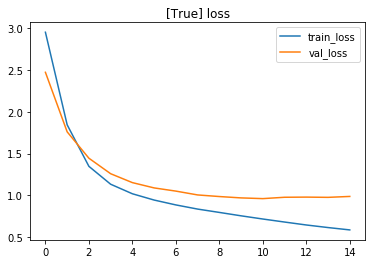

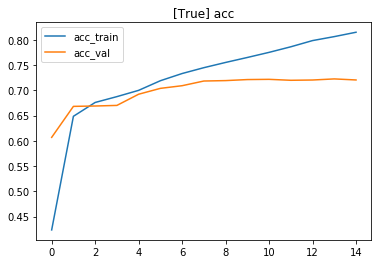

In [7]:
params = {}
params["trainData"] = "UK"
params["testData"] = "DE"
params["epochs"] = 15
params["batchSize"] = 1024
params["trainexamples"] = 1000 * 100

path = '/content/gdrive/My Drive/nlp/blobs/' + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + "/"
os.mkdir(path)
print("saving to:", path)


#done: [True,50], 
architectures = [ [True] ]

f = open(path + "info.txt", "w")
f.write(str(params)+"\n architectures: "+str(architectures))
f.close()

for a in architectures:
  dataset_train, feed_dict_train, length_train = amazon_multilingual.getData(params["trainData"], shuffle=True, batchsize=params["batchSize"])
  dataset_val, feed_dict_val, length_val = amazon_multilingual.getData(params["testData"], shuffle=False, batchsize=params["batchSize"])
  
  dataset_train = dataset_train.take(int(params["trainexamples"]/params["batchSize"]))
  dataset_val = dataset_val.take(int(params["trainexamples"]/params["batchSize"]))
  
  iterator = tf.data.Iterator.from_structure(dataset_train.output_types, dataset_train.output_shapes)
  train_iterator = iterator.make_initializer(dataset_train)
  val_iterator = iterator.make_initializer(dataset_val)
  text_input, label = iterator.get_next()
  
  xling = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-xling/en-de/1", trainable=a[0])
  model = Model(text_input, label, a[1:], xling)
  print(str(a))
  %time loss_hist_epoch, acc_hist_epoch, val_loss_hist_epoch, val_acc_hist_epoch = trainModel(model, params["epochs"])
  print("\t", loss_hist_epoch, acc_hist_epoch, "\n\t", val_loss_hist_epoch, val_acc_hist_epoch)
  plotResults(loss_hist_epoch, "train_loss", val_loss_hist_epoch, "val_loss", str(a)+" loss", path, a)
  plotResults(acc_hist_epoch, "acc_train", val_acc_hist_epoch, "acc_val", str(a)+ " acc", path, a)
  
  tf.reset_default_graph()
  del model, xling, dataset_train, feed_dict_train, length_train, dataset_val, feed_dict_val, length_val, iterator,train_iterator,val_iterator,text_input, label
  tf.reset_default_graph()

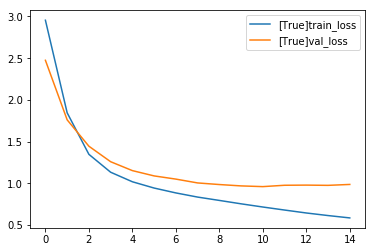

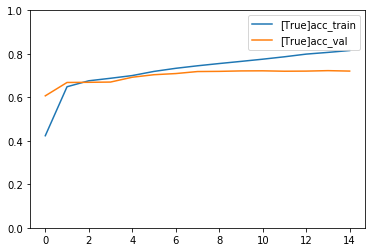

In [8]:
for f in glob.glob(path+"*loss.npy"):
  x = np.load(f)
  plt.plot(x, label=f[len(path):-4])
plt.legend()
plt.savefig(path+"allloss.png")
plt.show()

for f in glob.glob(path+"*acc*.npy"):
  x = np.load(f)
  plt.plot(x, label=f[len(path):-4])
plt.legend()
plt.ylim(0,1)
plt.savefig(path+"allacc.png")
plt.show()